# Full Circuit V2

## Prep Stage

In [1]:
import cirq
from scipy import constants

from recirq import fermi_hubbard
from recirq.fermi_hubbard import parameters

import numpy as np
from qiskit_nature.second_q.hamiltonians import QuadraticHamiltonian
from qiskit_nature.second_q.circuit.library import SlaterDeterminant
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import XXPlusYYGate

from qiskit import IBMQ, assemble
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.providers.jobstatus import JobStatus
from qiskit.quantum_info.operators import Operator

import matplotlib.pyplot as plt

J = 1
U = 2

# Time step in units of hbar/J
dt = (0.3*constants.hbar)/J

K_angle = - (dt * J)/constants.hbar
CPHASE_angle = (dt * U)/constants.hbar
print(K_angle)
print(CPHASE_angle)
print(K_angle + np.pi/2)

-0.3
0.6
1.2707963267948965


## Generate Hamiltonians

In [3]:
up_potential = parameters.GaussianTrappingPotential(particles=2, center=0.5, sigma=0.14285714285714285, scale=-4).get_potential(8)
up_hamiltonian = parameters._potential_to_quadratic_hamiltonian(up_potential, 1)
_, up_transform, _ = up_hamiltonian.diagonalizing_bogoliubov_transform()

down_potential = parameters.UniformTrappingPotential(particles=2).get_potential(8)
down_hamiltonian = parameters._potential_to_quadratic_hamiltonian(down_potential, 1)
_, down_transform, _ = down_hamiltonian.diagonalizing_bogoliubov_transform()
print(down_transform)

[[ 1.61229842e-01  3.03012985e-01  4.08248290e-01  4.64242827e-01
   4.64242827e-01  4.08248290e-01  3.03012985e-01  1.61229842e-01]
 [-3.03012985e-01 -4.64242827e-01 -4.08248290e-01 -1.61229842e-01
   1.61229842e-01  4.08248290e-01  4.64242827e-01  3.03012985e-01]
 [-4.08248290e-01 -4.08248290e-01  1.59161671e-16  4.08248290e-01
   4.08248290e-01 -2.64637082e-16 -4.08248290e-01 -4.08248290e-01]
 [-4.64242827e-01 -1.61229842e-01  4.08248290e-01  3.03012985e-01
  -3.03012985e-01 -4.08248290e-01  1.61229842e-01  4.64242827e-01]
 [-4.64242827e-01  1.61229842e-01  4.08248290e-01 -3.03012985e-01
  -3.03012985e-01  4.08248290e-01  1.61229842e-01 -4.64242827e-01]
 [-4.08248290e-01  4.08248290e-01  2.60915794e-16 -4.08248290e-01
   4.08248290e-01  2.83314733e-16 -4.08248290e-01  4.08248290e-01]
 [ 3.03012985e-01 -4.64242827e-01  4.08248290e-01 -1.61229842e-01
  -1.61229842e-01  4.08248290e-01 -4.64242827e-01  3.03012985e-01]
 [-1.61229842e-01  3.03012985e-01 -4.08248290e-01  4.64242827e-01
  -

## Initialisation Circuits

In [7]:
def initialise_circuit(circuit):
    occupied_orbitals = (1,0)
    up_circuit = SlaterDeterminant(up_transform[list(occupied_orbitals)])
    down_circuit = SlaterDeterminant(down_transform[list(occupied_orbitals)])
    circuit.append(up_circuit, register[0:8])
    circuit.append(down_circuit, register[8:16])

def takeMeasure(nmax):
    arr = list(range(0, nmax))
    circuit.measure(arr, arr)

register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register, classical)
#initialise_circuit(circuit)

#circuit.draw("mpl")

## Trotter Step

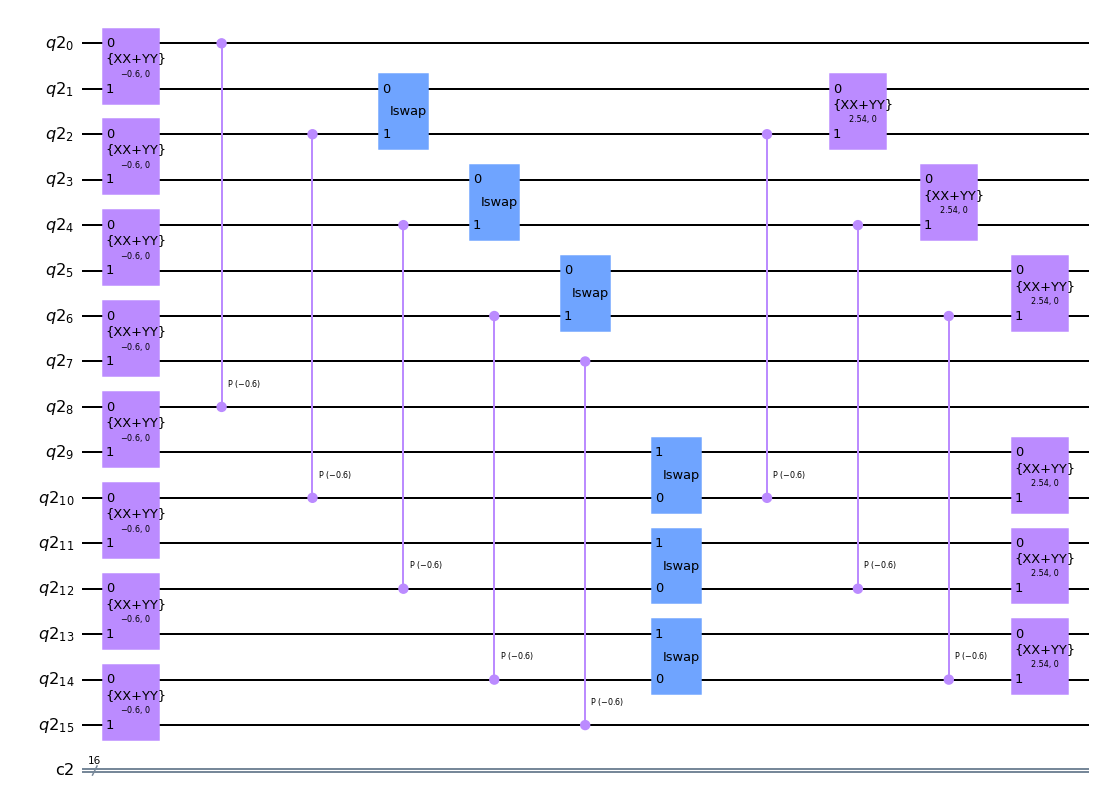

In [8]:
# Set-up SqrtISWAP gate
sqrt2 = np.sqrt(2)
SqrtISWAP = Operator( [
    [1, 0, 0, 0],
    [0, 1/sqrt2, 1j/sqrt2, 0],
    [0, 1j/sqrt2, 1/sqrt2, 0],
    [0, 0, 0, 1] ])

def addKGate(a,b, theta):
    XXYYGate = XXPlusYYGate(2*theta,0)
    circuit.append(XXYYGate, [a,b])

#def addKGate(a,b,theta):
#    circuit.rz(-np.pi/4, a)
#    circuit.rz(np.pi/4, b)
#    circuit.unitary(SqrtISWAP, [a,b])
#    circuit.rz(theta, a)
#    circuit.rz(-theta, b)
#    circuit.unitary(SqrtISWAP.adjoint(), [a,b])
#    circuit.rz(np.pi/4, a)
#    circuit.rz(-np.pi/4, b)

def addCPHASE(a,b,theta):
    circuit.cp(-theta, a,b)

def addiSwap(a,b):
    circuit.iswap(a,b)

def addTrotter(n):
    # J odd
    i=0
    while i<n-1:
        addKGate(i, i+1, K_angle)
        i+=2
        
    # U odd
    i=0
    while i<7:
        addCPHASE(i, i + 8, CPHASE_angle)
        i+=2
        
    # iSwap
    i=1
    while i<7:
        addiSwap(i, i+1)
        i+=2
    i=9
    while i<14:
        addiSwap(i+1, i)
        i+=2
        
    # U even
    i=2
    while i<7:
        addCPHASE(i, i + 8, CPHASE_angle)
        i+=2
    addCPHASE(7, 15, CPHASE_angle)
    
    # J even iSwap adjoint
    i=1
    while i<7:
        addKGate(i, i+1, K_angle + np.pi/2)
        i+=2
    i=9

    while i<14:
        addKGate(i, i+1, K_angle + np.pi/2)
        i+=2
    
n_trotter = 1

j=0
while(j < n_trotter):
    addTrotter(16)
    j += 1

#takeMeasure(16)

circuit.draw("mpl")

## Process Circuit on IBMQ Simulator

In [5]:
provider = IBMQ.load_account()
backend = provider.backend.simulator_statevector
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())
#print(job.result().data())

<ipython-input-5-af8350adeb97>:1: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  provider = IBMQ.load_account()
<ipython-input-5-af8350adeb97>:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


## Post-Processing 

[  11.  313. 1354. 2320. 2352. 1317.  315.   18.]
[ 609. 1411. 1142.  825.  861. 1188. 1377.  587.]


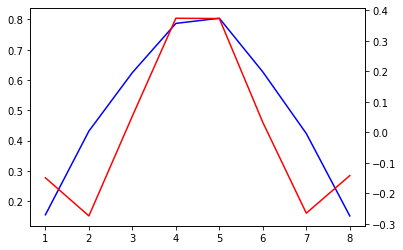

In [6]:
results = job.result().data()
up_site_count = np.zeros(8)
down_site_count = np.zeros(8)

for i in results["counts"]:
    bitstr = bin(int(i, 16))[2:].zfill(16)
    for j in range(len(up_site_count)):
        if bitstr[j] == "1":
            down_site_count[j] += results["counts"][i]
        if bitstr[j+8] == "1":
            up_site_count[j] += results["counts"][i]

up_site_count = up_site_count[::-1]
down_site_count = down_site_count[::-1]

print(up_site_count)
print(down_site_count)
average = np.average(up_site_count)
up_site_count = up_site_count/4000
down_site_count = down_site_count/4000

up_density = np.zeros(8)
down_density = np.zeros(8)

up_density = up_site_count + down_site_count
down_density = up_site_count - down_site_count

import matplotlib.pyplot as plt

x = np.arange(1, 9, 1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, up_density, color='b')
ax2.plot(x, down_density, color='r')
plt.show()

## Iterations of Trotter steps

Here we iterate over all of the Trotter steps in order to produce the charge and spin seperations.

In [7]:
all_up_density = np.zeros([11,8])
all_down_density = np.zeros([11,8])

all_up_count = np.zeros([11,8])
all_down_count = np.zeros([11,8])

### $\eta = 0$

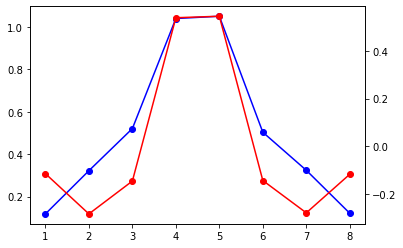

In [8]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register, classical)
initialise_circuit(circuit)

n_trotter = 0

j=0
while(j < n_trotter):
    addTrotter(16)
    j += 1

takeMeasure(16)

transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

results = job.result().data()
up_site_count = np.zeros(8)
down_site_count = np.zeros(8)

for i in results["counts"]:
    bitstr = bin(int(i, 16))[2:].zfill(16)
    for j in range(len(up_site_count)):
        if bitstr[j] == "1":
            down_site_count[j] += results["counts"][i]
        if bitstr[j+8] == "1":
            up_site_count[j] += results["counts"][i]

up_site_count = up_site_count[::-1]
down_site_count = down_site_count[::-1]

average = np.average(up_site_count)
up_site_count = up_site_count/4000
down_site_count = down_site_count/4000

all_up_count[0] = up_site_count
all_down_count[0] = down_site_count

up_density = np.zeros(8)
down_density = np.zeros(8)

up_density = up_site_count + down_site_count
down_density = up_site_count - down_site_count

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, up_density, '-ob')
ax2.plot(x, down_density, '-or')
plt.show()

all_up_density[0] = up_density
all_down_density[0] = down_density

### $\eta = 1$

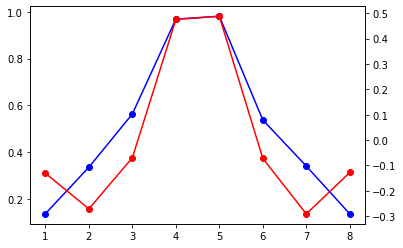

In [9]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register, classical)
initialise_circuit(circuit)

n_trotter = 1

j=0
while(j < n_trotter):
    addTrotter(16)
    j += 1

takeMeasure(16)

transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

results = job.result().data()
up_site_count = np.zeros(8)
down_site_count = np.zeros(8)

for i in results["counts"]:
    bitstr = bin(int(i, 16))[2:].zfill(16)
    for j in range(len(up_site_count)):
        if bitstr[j] == "1":
            down_site_count[j] += results["counts"][i]
        if bitstr[j+8] == "1":
            up_site_count[j] += results["counts"][i]

up_site_count = up_site_count[::-1]
down_site_count = down_site_count[::-1]

average = np.average(up_site_count)
up_site_count = up_site_count/4000
down_site_count = down_site_count/4000

all_up_count[1] = up_site_count
all_down_count[1] = down_site_count

up_density = np.zeros(8)
down_density = np.zeros(8)

up_density = up_site_count + down_site_count
down_density = up_site_count - down_site_count

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, up_density, '-ob')
ax2.plot(x, down_density, '-or')
plt.show()

all_up_density[1] = up_density
all_down_density[1] = down_density

### $\eta = 2$

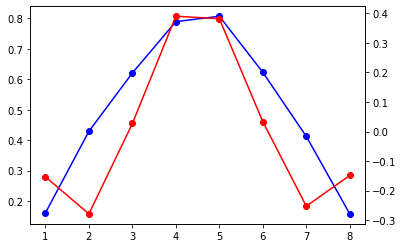

In [10]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register, classical)
initialise_circuit(circuit)

n_trotter = 2

j=0
while(j < n_trotter):
    addTrotter(16)
    j += 1

takeMeasure(16)

transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

results = job.result().data()
up_site_count = np.zeros(8)
down_site_count = np.zeros(8)

for i in results["counts"]:
    bitstr = bin(int(i, 16))[2:].zfill(16)
    for j in range(len(up_site_count)):
        if bitstr[j] == "1":
            down_site_count[j] += results["counts"][i]
        if bitstr[j+8] == "1":
            up_site_count[j] += results["counts"][i]

up_site_count = up_site_count[::-1]
down_site_count = down_site_count[::-1]

average = np.average(up_site_count)
up_site_count = up_site_count/4000
down_site_count = down_site_count/4000

all_up_count[2] = up_site_count
all_down_count[2] = down_site_count

up_density = np.zeros(8)
down_density = np.zeros(8)

up_density = up_site_count + down_site_count
down_density = up_site_count - down_site_count

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, up_density, '-ob')
ax2.plot(x, down_density, '-or')
plt.show()

all_up_density[2] = up_density
all_down_density[2] = down_density

### $\eta = 3$

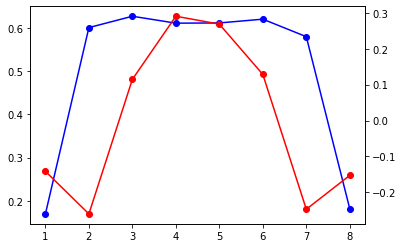

In [11]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register, classical)
initialise_circuit(circuit)

n_trotter = 3

j=0
while(j < n_trotter):
    addTrotter(16)
    j += 1

takeMeasure(16)

transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

results = job.result().data()
up_site_count = np.zeros(8)
down_site_count = np.zeros(8)

for i in results["counts"]:
    bitstr = bin(int(i, 16))[2:].zfill(16)
    for j in range(len(up_site_count)):
        if bitstr[j] == "1":
            down_site_count[j] += results["counts"][i]
        if bitstr[j+8] == "1":
            up_site_count[j] += results["counts"][i]

up_site_count = up_site_count[::-1]
down_site_count = down_site_count[::-1]

average = np.average(up_site_count)
up_site_count = up_site_count/4000
down_site_count = down_site_count/4000

all_up_count[3] = up_site_count
all_down_count[3] = down_site_count

up_density = np.zeros(8)
down_density = np.zeros(8)

up_density = up_site_count + down_site_count
down_density = up_site_count - down_site_count

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, up_density, '-ob')
ax2.plot(x, down_density, '-or')
plt.show()

all_up_density[3] = up_density
all_down_density[3] = down_density

### $\eta = 4$

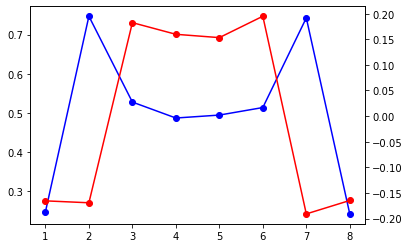

In [12]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register, classical)
initialise_circuit(circuit)

n_trotter = 4

j=0
while(j < n_trotter):
    addTrotter(16)
    j += 1

takeMeasure(16)

transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

results = job.result().data()
up_site_count = np.zeros(8)
down_site_count = np.zeros(8)

for i in results["counts"]:
    bitstr = bin(int(i, 16))[2:].zfill(16)
    for j in range(len(up_site_count)):
        if bitstr[j] == "1":
            down_site_count[j] += results["counts"][i]
        if bitstr[j+8] == "1":
            up_site_count[j] += results["counts"][i]

up_site_count = up_site_count[::-1]
down_site_count = down_site_count[::-1]

average = np.average(up_site_count)
up_site_count = up_site_count/4000
down_site_count = down_site_count/4000

all_up_count[4] = up_site_count
all_down_count[4] = down_site_count

up_density = np.zeros(8)
down_density = np.zeros(8)

up_density = up_site_count + down_site_count
down_density = up_site_count - down_site_count

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, up_density, '-ob')
ax2.plot(x, down_density, '-or')
plt.show()

all_up_density[4] = up_density
all_down_density[4] = down_density

### $\eta = 5$

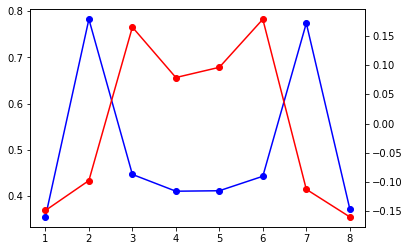

In [13]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register, classical)
initialise_circuit(circuit)

n_trotter = 5

j=0
while(j < n_trotter):
    addTrotter(16)
    j += 1

takeMeasure(16)

transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

results = job.result().data()
up_site_count = np.zeros(8)
down_site_count = np.zeros(8)

for i in results["counts"]:
    bitstr = bin(int(i, 16))[2:].zfill(16)
    for j in range(len(up_site_count)):
        if bitstr[j] == "1":
            down_site_count[j] += results["counts"][i]
        if bitstr[j+8] == "1":
            up_site_count[j] += results["counts"][i]

up_site_count = up_site_count[::-1]
down_site_count = down_site_count[::-1]

average = np.average(up_site_count)
up_site_count = up_site_count/4000
down_site_count = down_site_count/4000

all_up_count[5] = up_site_count
all_down_count[5] = down_site_count

up_density = np.zeros(8)
down_density = np.zeros(8)

up_density = up_site_count + down_site_count
down_density = up_site_count - down_site_count

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, up_density, '-ob')
ax2.plot(x, down_density, '-or')
plt.show()

all_up_density[5] = up_density
all_down_density[5] = down_density

### $\eta = 6$

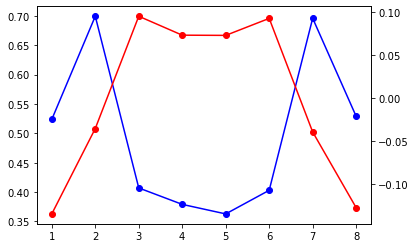

In [14]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register, classical)
initialise_circuit(circuit)

n_trotter = 6

j=0
while(j < n_trotter):
    addTrotter(16)
    j += 1

takeMeasure(16)

transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

results = job.result().data()
up_site_count = np.zeros(8)
down_site_count = np.zeros(8)

for i in results["counts"]:
    bitstr = bin(int(i, 16))[2:].zfill(16)
    for j in range(len(up_site_count)):
        if bitstr[j] == "1":
            down_site_count[j] += results["counts"][i]
        if bitstr[j+8] == "1":
            up_site_count[j] += results["counts"][i]

up_site_count = up_site_count[::-1]
down_site_count = down_site_count[::-1]

average = np.average(up_site_count)
up_site_count = up_site_count/4000
down_site_count = down_site_count/4000

all_up_count[6] = up_site_count
all_down_count[6] = down_site_count

up_density = np.zeros(8)
down_density = np.zeros(8)

up_density = up_site_count + down_site_count
down_density = up_site_count - down_site_count

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, up_density, '-ob')
ax2.plot(x, down_density, '-or')
plt.show()

all_up_density[6] = up_density
all_down_density[6] = down_density

### $\eta = 7$

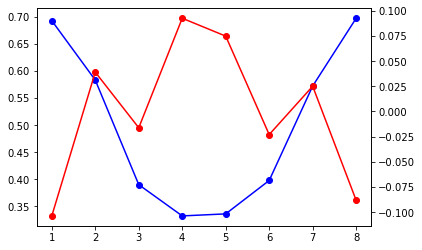

In [15]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register, classical)
initialise_circuit(circuit)

n_trotter = 7

j=0
while(j < n_trotter):
    addTrotter(16)
    j += 1

takeMeasure(16)

transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

results = job.result().data()
up_site_count = np.zeros(8)
down_site_count = np.zeros(8)

for i in results["counts"]:
    bitstr = bin(int(i, 16))[2:].zfill(16)
    for j in range(len(up_site_count)):
        if bitstr[j] == "1":
            down_site_count[j] += results["counts"][i]
        if bitstr[j+8] == "1":
            up_site_count[j] += results["counts"][i]

up_site_count = up_site_count[::-1]
down_site_count = down_site_count[::-1]

average = np.average(up_site_count)
up_site_count = up_site_count/4000
down_site_count = down_site_count/4000

all_up_count[7] = up_site_count
all_down_count[7] = down_site_count

up_density = np.zeros(8)
down_density = np.zeros(8)

up_density = up_site_count + down_site_count
down_density = up_site_count - down_site_count

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, up_density, '-ob')
ax2.plot(x, down_density, '-or')
plt.show()

all_up_density[7] = up_density
all_down_density[7] = down_density

### $\eta = 8$

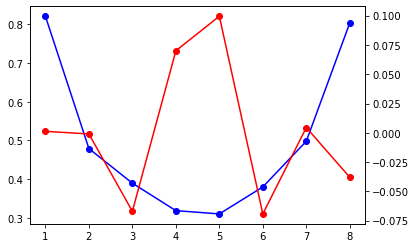

In [16]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register, classical)
initialise_circuit(circuit)

n_trotter = 8

j=0
while(j < n_trotter):
    addTrotter(16)
    j += 1

takeMeasure(16)

transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

results = job.result().data()
up_site_count = np.zeros(8)
down_site_count = np.zeros(8)

for i in results["counts"]:
    bitstr = bin(int(i, 16))[2:].zfill(16)
    for j in range(len(up_site_count)):
        if bitstr[j] == "1":
            down_site_count[j] += results["counts"][i]
        if bitstr[j+8] == "1":
            up_site_count[j] += results["counts"][i]

up_site_count = up_site_count[::-1]
down_site_count = down_site_count[::-1]

average = np.average(up_site_count)
up_site_count = up_site_count/4000
down_site_count = down_site_count/4000

all_up_count[8] = up_site_count
all_down_count[8] = down_site_count

up_density = np.zeros(8)
down_density = np.zeros(8)

up_density = up_site_count + down_site_count
down_density = up_site_count - down_site_count

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, up_density, '-ob')
ax2.plot(x, down_density, '-or')
plt.show()

all_up_density[8] = up_density
all_down_density[8] = down_density

### $\eta = 9$

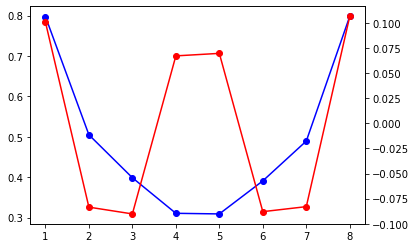

In [17]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register, classical)
initialise_circuit(circuit)

n_trotter = 9

j=0
while(j < n_trotter):
    addTrotter(16)
    j += 1

takeMeasure(16)

transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

results = job.result().data()
up_site_count = np.zeros(8)
down_site_count = np.zeros(8)

for i in results["counts"]:
    bitstr = bin(int(i, 16))[2:].zfill(16)
    for j in range(len(up_site_count)):
        if bitstr[j] == "1":
            down_site_count[j] += results["counts"][i]
        if bitstr[j+8] == "1":
            up_site_count[j] += results["counts"][i]

up_site_count = up_site_count[::-1]
down_site_count = down_site_count[::-1]

average = np.average(up_site_count)
up_site_count = up_site_count/4000
down_site_count = down_site_count/4000

all_up_count[9] = up_site_count
all_down_count[9] = down_site_count

up_density = np.zeros(8)
down_density = np.zeros(8)

up_density = up_site_count + down_site_count
down_density = up_site_count - down_site_count

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, up_density, '-ob')
ax2.plot(x, down_density, '-or')
plt.show()

all_up_density[9] = up_density
all_down_density[9] = down_density

### $\eta = 10$

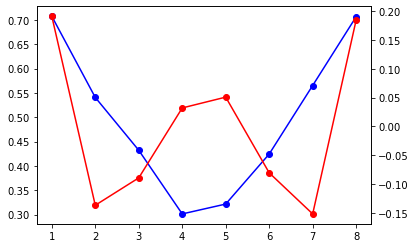

In [18]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register, classical)
initialise_circuit(circuit)

n_trotter = 10

j=0
while(j < n_trotter):
    addTrotter(16)
    j += 1

takeMeasure(16)

transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

results = job.result().data()
up_site_count = np.zeros(8)
down_site_count = np.zeros(8)

for i in results["counts"]:
    bitstr = bin(int(i, 16))[2:].zfill(16)
    for j in range(len(up_site_count)):
        if bitstr[j] == "1":
            down_site_count[j] += results["counts"][i]
        if bitstr[j+8] == "1":
            up_site_count[j] += results["counts"][i]

up_site_count = up_site_count[::-1]
down_site_count = down_site_count[::-1]

average = np.average(up_site_count)
up_site_count = up_site_count/4000
down_site_count = down_site_count/4000

all_up_count[10] = up_site_count
all_down_count[10] = down_site_count

up_density = np.zeros(8)
down_density = np.zeros(8)

up_density = up_site_count + down_site_count
down_density = up_site_count - down_site_count

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, up_density, '-ob')
ax2.plot(x, down_density, '-or')
plt.show()

all_up_density[10] = up_density
all_down_density[10] = down_density

## Compute and Plot Charge and Spin Spreads

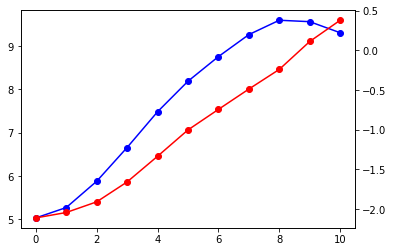

In [19]:
k_plus = np.zeros(11)
k_minus = np.zeros(11)
L = 8

for i in range(len(k_plus)):
    sum_up = 0
    sum_down = 0
    for j in range(len(all_up_density[0])):
        sum_up += abs((j+1) - (L + 1)/2) * all_up_density[i][j]
    k_plus[i] = sum_up
    for j in range(len(all_down_density[0])):
        sum_down += abs((j+1) - (L + 1)/2) * all_down_density[i][j]
    k_minus[i] = sum_down
    
x = np.arange(0, 11, 1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x, k_plus, '-ob')
ax2.plot(x, k_minus, '-or')
plt.show()

In [20]:
print(k_plus)
print(k_minus)

[5.03475 5.274   5.881   6.6605  7.48575 8.191   8.75925 9.26725 9.599
 9.566   9.31075]
[-2.11025 -2.042   -1.908   -1.657   -1.33375 -1.002   -0.74325 -0.48725
 -0.2395   0.112    0.37975]


In [21]:
f = open("charge_density.txt", "a")
for j in range(len(all_up_density)):
    for i in range(len(all_up_density[j])):
        f.write(str(all_up_density[j][i]) + "\n")
f.close()

In [22]:
f = open("spin_density.txt", "a")
for j in range(len(all_down_density)):
    for i in range(len(all_down_density[j])):
        f.write(str(all_down_density[j][i]) + "\n")
f.close()

In [23]:
f = open("charge_spreading.txt", "a")
for i in range(len(k_plus)):
    f.write(str(k_plus[i]) + "\n")
f.close()

In [24]:
f = open("spin_spreading.txt", "a")
for i in range(len(k_plus)):
    f.write(str(k_minus[i]) + "\n")
f.close()

In [25]:
f = open("up_density.txt", "a")
for j in range(len(all_up_count)):
    for i in range(len(all_up_count[j])):
        f.write(str(all_up_count[j][i]) + "\n")
f.close()

f = open("down_density.txt", "a")
for j in range(len(all_down_count)):
    for i in range(len(all_down_count[j])):
        f.write(str(all_down_count[j][i]) + "\n")
f.close()